In [ ]:
# 获取数据
%reload_ext autoreload
%autoreload 2
import sys
# 替换为fun.py实际所在的绝对路径（比如："D:/projects/common_code"） D:\桌面\策略\fun.py
sys.path.append("D://桌面/策略")
from fun import *
import polars as pl
import pandas as pd
import datetime as dt
import time 
import tinyshare as tns

ts_token = 'YzAEH11Yc7jZCHjeJa63fnbpSt3k9Je3GvWn0390oiBKO95bVJjP7u5L34e2ff6b'
ts =tns.pro_api(ts_token)

start_date = dt.date(2024,1,1)
end_date = dt.date(2025,10,1)
stock_list = ts.index_weight(index_code='000300.SH', start_date=start_date.strftime('%Y%m%d'), end_date=end_date.strftime('%Y%m%d'))['con_code'].tolist()
stock_list = convert_code_format(stock_list)

# 获取指定日期的日线数据
stock_data = read_day_data(start_date=start_date,end_date=end_date,stock_list=stock_list,file_path='ts_stock_all_data').sort(['code','trading_date'])
stock_data = stock_data.drop_nulls(subset=['open','close','pre_close','limit_up','limit_down'])

# 选取复权的收盘价为计算基础
close_data = read_day_data(start_date=start_date-dt.timedelta(days=30),end_date=end_date+dt.timedelta(days=20))
adj_data = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_adj')
close_data = close_data.drop_nulls(subset=['open','close','pre_close','limit_up','limit_down']).join(
    adj_data.select(['trading_date','code','adj_factor']),
    on=['trading_date','code'],
    how='left'
).with_columns(
    adjusted_close = pl.col('close') * pl.col('adj_factor')
)
close = close_data.to_pandas().pivot(index='trading_date',columns='code',values='adjusted_close')
#stock_data.schema


2025-12-09 17:19:06,413 - DEBUG - Starting new HTTPS connection (1): 115.159.100.200:443
2025-12-09 17:19:06,749 - DEBUG - https://115.159.100.200:443 "POST /api/tushare/index_weight HTTP/1.1" 200 None


In [6]:
# 计算因子
# 1.计算distance(distance=1-person(股票1pct,股票2pct,windows=60))
pct = stock_data.to_pandas().pivot(index='trading_date',columns='code',values='pct')
trading_dates = pct.index.tolist()
codes = pct.columns.tolist()
def cal_distance(pct_pivot,window=60):
    """从pct_pivot:pd.dataframe中计算每日的距离两两股票的矩阵(index为日期,columns为股票代码,values为pct)"""
    from scipy.spatial.distance import pdist,squareform
    distance_dict = {}
    for i in range(window,len(pct_pivot)):
        date = pct_pivot.index[i]
        data_window = pct_pivot.iloc[i-window:i]
        corr_matrix = data_window.corr()
        dist_matrix = 1 - corr_matrix
        distance_dict[date] = dist_matrix
    return distance_dict
distance_dict = cal_distance(
    read_day_data(
        start_date=start_date-dt.timedelta(days=30),end_date=end_date,stock_list=stock_list
        ).to_pandas().pivot(index='trading_date',columns='code',values='close'),
    window=30
)

# 2.计算参考价值(每一个股票distance最小的10个股票的平均价格)
refer_price = pd.DataFrame(index=pct.index,columns=pct.columns)
for date,dist_matrix in distance_dict.items():
    if date not in refer_price.index:
        continue
    close_on_date = close.loc[date]
    for stock in dist_matrix.columns:
        nearest_stocks = dist_matrix[stock].nsmallest(11).index  # 包含自身
        nearest_stocks = nearest_stocks[nearest_stocks != stock]  # 排除自身
        if stock not in refer_price.columns:
            continue
        refer_price.loc[date,stock] = round(close_on_date[nearest_stocks].mean(), 4) # 保留4位小数

# 3.计算价差偏离度因子(factor = (log(close)-log(refer_price)))
factor = pd.DataFrame(index=pct.index,columns=pct.columns)
for date in trading_dates:
    for stock in codes:
        if pd.notna(close.loc[date,stock]) and pd.notna(refer_price.loc[date,stock]):
            factor.loc[date,stock] = round(np.log(close.loc[date,stock]) - np.log(refer_price.loc[date,stock]), 4)  # 保留4位小数

factor.head()

code,SHSE.600000,SHSE.600009,SHSE.600010,SHSE.600011,SHSE.600015,SHSE.600016,SHSE.600018,SHSE.600019,SHSE.600023,SHSE.600025,...,SZSE.300782,SZSE.300832,SZSE.300896,SZSE.300919,SZSE.300957,SZSE.300979,SZSE.300999,SZSE.301236,SZSE.301269,SZSE.302132
trading_date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


开始因子分析: 2024-01-01 ~ 2025-10-01 | 持仓5天 | 调仓1天
有效交易日: 410 | 调仓日: 410

==== 一、IC/IR分析（纯宽表计算） ====
IC均值: -0.0113 | IC_IR: -0.0936 | IC>0占比: 48.54%
RankIC均值: -0.0158 | RankIC_IR: -0.1279 | RankIC>0占比: 47.56%

==== 二、分组收益分析 ====
分组收益统计:
  group  mean_daily_ret  annual_ret   sharpe  max_dd  pos_ratio
0    G1          0.0049      0.2480  53.2973 -0.4861     0.5415
1    G2          0.0047      0.2364  50.7612 -0.4997     0.5634
2    G3          0.0049      0.2456  51.3273 -0.5607     0.5561
3    G4          0.0046      0.2342  43.3431 -0.6435     0.5415
4    G5          0.0041      0.2070  36.9460 -0.6807     0.5171


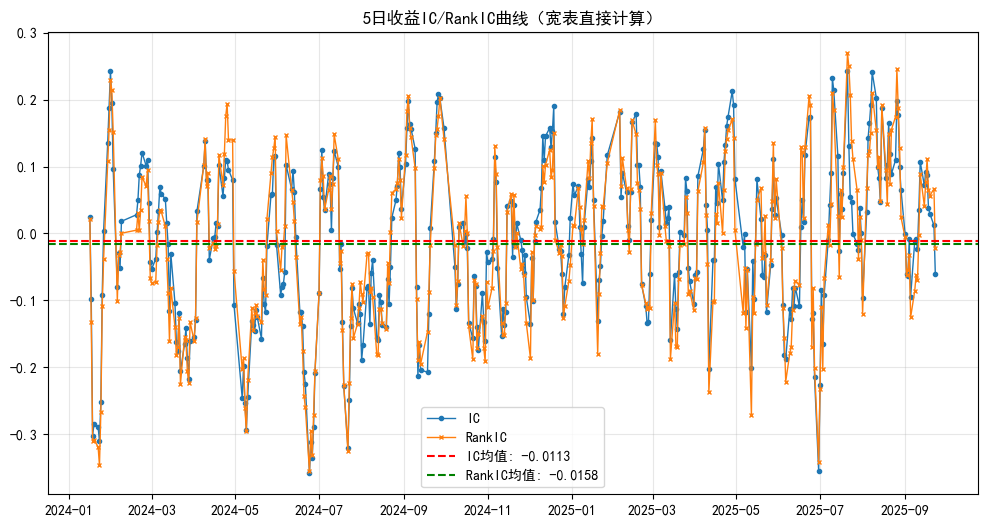

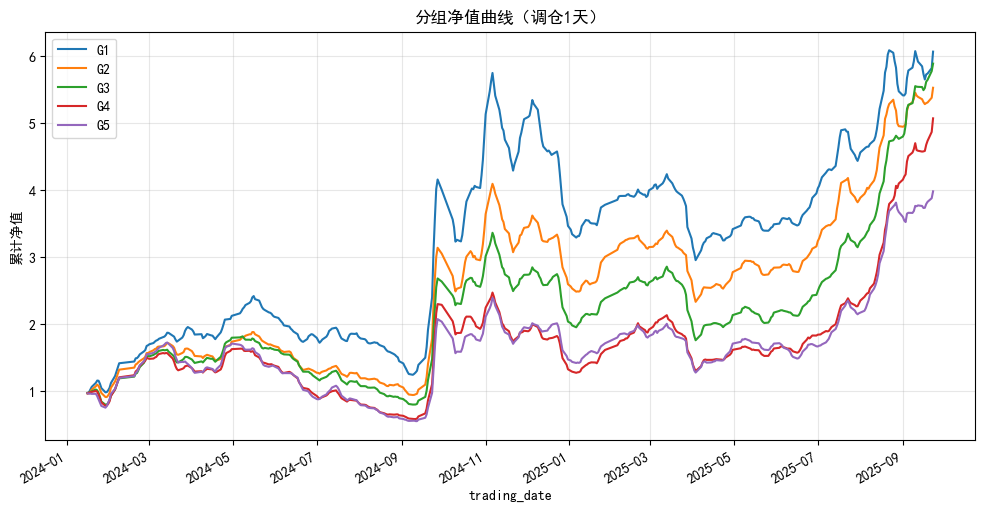

In [7]:
from alpha import *
a=analyze_factor(factor_data=factor,
               close_data=close,
               start_date=start_date,
               end_date=end_date,
               return_period=5,
               group_num=5,)